In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import numpy as np
from pandas import Series
import seaborn as sns
from matplotlib.pyplot import figure
import cmocean.cm as cmo
import seaborn as sns

from pylab import rcParams
from numpy import diff
from scipy import interpolate
import scipy.stats as stats

from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

import matplotlib.gridspec as gridspec
from IPython.display import display, Math

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
df_iron = pd.read_csv('../Dissertation_projects/Data/IRON/Iron.csv', sep=',', index_col=0)

#make all the spots labeled NA a nan value
df_iron = df_iron.replace('NA', np.nan)
df_iron = df_iron.replace('NA ', np.nan)

#make all BDL a 0 
df_iron.loc[df_iron['FeT_uM'] == 'BLD', 'FeT_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] == 'BLD', 'Fe2_uM'] = 0

# convert columns to numeric data type
df_iron['FeT_uM'] = pd.to_numeric(df_iron['FeT_uM'], errors='coerce')
df_iron['Fe2_uM'] = pd.to_numeric(df_iron['Fe2_uM'], errors='coerce')

df_iron['FeT_uM'] = df_iron['FeT_uM'].where(pd.notna(df_iron['FeT_uM']), other=np.nan)
df_iron['Fe2_uM'] = df_iron['Fe2_uM'].where(pd.notna(df_iron['Fe2_uM']), other=np.nan)

#make all negative a 0 
df_iron.loc[df_iron['FeT_uM'] < 0, 'FeT_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] < 0, 'Fe2_uM'] = 0

#calculate Fe +3 
df_iron['Fe3_uM'] = df_iron['FeT_uM'] - df_iron['Fe2_uM']
df_iron.loc[df_iron['Fe3_uM'] < 0, 'Fe3_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] > df_iron['FeT_uM'], 'Fe3_uM'] = 0
df_iron['Fe3_uM'] = pd.to_numeric(df_iron['Fe3_uM'], errors='coerce')
df_iron['Fe3_uM'] = df_iron['Fe3_uM'].where(pd.notna(df_iron['Fe3_uM']), other=np.nan)

#time feild 
df_iron['Fe2_Time'] = pd.to_numeric(df_iron['Fe2_Time'], errors='coerce')
df_iron['Fe2_Time'] = df_iron['Fe2_Time'].where(pd.notna(df_iron['Fe2_Time']), other=np.nan)

#time feild 
df_iron['FeT_Time'] = pd.to_numeric(df_iron['FeT_Time'], errors='coerce')
df_iron['FeT_Time'] = df_iron['FeT_Time'].where(pd.notna(df_iron['FeT_Time']), other=np.nan)

# convert columns to numeric data type
df_iron['FeT_Depth'] = pd.to_numeric(df_iron['Fe2_Depth'], errors='coerce')
df_iron['Fe2_Depth'] = pd.to_numeric(df_iron['Fe2_Depth'], errors='coerce')

df_iron['FeT_uM'] = df_iron['FeT_uM'].replace(0, np.nan)
df_iron['Fe2_uM'] = df_iron['Fe2_uM'].replace(0, np.nan)
df_iron['Fe3_uM'] = df_iron['Fe3_uM'].replace(0, np.nan)


df_iron['code'] = df_iron['Location'] + '_' + df_iron['Campaign']

In [3]:
df_doc = pd.read_csv('../Dissertation_projects/Data/TOC/TOC_GOM.csv', sep=',', index_col=0)

#make all BDL a 0 
df_doc.loc[df_doc['NPOC_uM'] == 'BLD', 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] == 'BLD', 'TN_uM'] = 0

df_doc.loc[df_doc['NPOC_uM'] < 0, 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] < 0, 'TN_uM'] = 0

#fix date time 
df_doc['date_time'] = pd.to_datetime(df_doc['Date'])
df_doc['Date'] = df_doc['date_time'].dt.date

df_doc['NPOC_uM'] = pd.to_numeric(df_doc['NPOC_uM'], errors='coerce')
df_doc['NPOC_uM'] = df_doc['NPOC_uM'].where(pd.notna(df_doc['NPOC_uM']), other=np.nan)

df_doc['TN_uM'] = pd.to_numeric(df_doc['TN_uM'], errors='coerce')
df_doc['TN_uM'] = df_doc['TN_uM'].where(pd.notna(df_doc['TN_uM']), other=np.nan)

df_doc['Time'] = pd.to_numeric(df_doc['Time'], errors='coerce')
df_doc['Time'] = df_doc['Time'].where(pd.notna(df_doc['Time']), other=np.nan)

df_doc['NPOC_uM'] = df_doc['NPOC_uM'].replace(0, np.nan)
df_doc['TN_uM'] = df_doc['TN_uM'].replace(0, np.nan)

df_doc['code'] = df_doc['Location'] + '_' + df_doc['Campaign']

In [4]:
df_meta = pd.read_csv('../Dissertation_projects/Data/meta_data.csv', sep=',', index_col=0)

#fix date time 
df_meta['date_time'] = pd.to_datetime(df_meta['Date'])
df_meta['Date'] = df_meta['date_time'].dt.date

df_meta['code'] = df_meta['Station'] + '_' + df_meta['Trip']

In [5]:
df_c = pd.read_csv('../Dissertation_projects/Data/CDOM/Outputs.csv', sep=',', index_col=0)

# Ensure that the indices are of the same type
df_c.index = df_c.index.astype(str)
df_meta.index = df_meta.index.astype(str)

# Concatenate the DataFrames
df_cdom = df_c.merge(df_meta, left_index=True, right_index=True)

In [6]:
df_spectra_pw = pd.read_csv('../Dissertation_projects/Data/CDOM/sprectra_pchip_baseline_corrected_PW.csv',sep=',', index_col=0)
df_spectra_rz = pd.read_csv('../Dissertation_projects/Data/CDOM/sprectra_pchip_baseline_corrected_RZ.csv',sep=',', index_col=0)

df_spectra_pw.columns = ['a' + col for col in df_spectra_pw.columns]
df_spectra_rz.columns = ['a' + col for col in df_spectra_rz.columns]

In [7]:
#get PW data sets 
df_cdom_pw = df_cdom[df_cdom['Type'] == 'PW']
df_iron_pw = df_iron[df_iron['Type'] == 'PW']
df_doc_pw = df_doc[df_doc['Type'] == 'PW']

#get RHZ data 
df_cdom_rz = df_cdom[df_cdom['Type'] == 'RHZ']
df_iron_rz = df_iron[df_iron['Type'].isin(['RZ', 'GBRZ'])]
df_doc_rz = df_doc[df_doc['Type'] == 'RZ']

In [8]:
df_iron_rz

,Treatment,Campaign,Location,Type,FeT_Date,FeT_uM,FeT_mgL,FeT_Notes,FeT_Depth,FeT_Time,Fe2_Date,Fe2_uM,Fe2_mgL,Fe2_Notes,Fe2_Depth,Fe2_Time,Fe3_uM,code
Sample_ID,,,,,,,,,,,,,,,,,,
215571,P2F,GOM21FA,St.16,RZ,11/13/2021,389.855891,21.77150226,St.16.11,2.0,NaN,11/13/2021,432.349398,24.14455211,St.16.11,2.0,NaN,NaN,St.16_GOM21FA
215572,P2F,GOM21FA,St.16,RZ,11/13/2021,506.647208,28.29371335,St.16.12,4.0,NaN,11/13/2021,471.005362,26.30329444,St.16.12,4.0,NaN,35.641846,St.16_GOM21FA
215573,P2F,GOM21FA,St.16,RZ,11/13/2021,311.943529,17.4204864,St.16.13,6.0,NaN,11/13/2021,355.051074,19.82782722,St.16.13,6.0,NaN,NaN,St.16_GOM21FA
215574,P2F,GOM21FA,St.16,RZ,11/13/2021,531.668078,29.69100381,St.16.14,8.0,NaN,11/13/2021,549.102016,30.66460209,St.16.14,8.0,NaN,NaN,St.16_GOM21FA
215575,P2F,GOM21FA,St.16,RZ,11/13/2021,564.986363,31.55166345,St.16.15,10.0,NaN,11/13/2021,495.226043,27.65589838,St.16.15,10.0,NaN,69.760320,St.16_GOM21FA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225383,P1F,GOM22SU,St.MK,GBRZ,7/23/2022,75.796000,4.233,NaN,6.0,NaN,7/24/2022,45.350000,2.53,NaN,6.0,NaN,30.446000,St.MK_GOM22SU
225384,P1F,GOM22SU,St.MK,GBRZ,7/23/2022,34.567000,1.93,NaN,8.0,NaN,7/24/2022,18.470000,1.03,NaN,8.0,NaN,16.097000,St.MK_GOM22SU
225385,P1F,GOM22SU,St.MK,GBRZ,7/23/2022,9.751000,0.545,NaN,10.0,NaN,7/24/2022,3.130000,0.17,NaN,10.0,NaN,6.621000,St.MK_GOM22SU


In [9]:
#Put all the PW data together 
#remove repeat rows 
df_cdom_pw_cl = df_cdom_pw.drop(['Date', 'Type', 'Notes', 'date_time', 'code', 'Trip', 'Salinity',
                                 'Station', 'Lat', 'Lon', 'Water_depth', 'Sample_depth',
                                 'Sample_depth_units', 'Wavguide_Path_lengths', 'BC_time',
                                 'BC_Chamber_vol_(L)', 'Waveguide_used', 'Flagged', 'file_id'], axis=1)
df_iron_pw_cl = df_iron_pw.drop(['Treatment', 'Campaign', 'Location', 'Type', 'code'], axis=1)
df_doc_pw_cl = df_doc_pw.drop(['Treatment', 'Campaign', 'Location','Date', 'Type','Depth', 'Notes', 
                               'Time','code','date_time'], axis=1)

df_cdom_pw_cl.index = df_cdom_pw_cl.index.astype(str)
df_iron_pw_cl.index = df_iron_pw_cl.index.astype(str)
df_doc_pw_cl.index = df_doc_pw_cl.index.astype(str)
df_spectra_pw.index = df_spectra_pw.index.astype(str)

#combind DOC and CDOM data 
df_pw = df_spectra_pw.join(df_doc_pw_cl)
df_pw = df_pw.join(df_cdom_pw_cl)

#match up the inxdes for the merge 
df_iron_pw_cl['sample_index'] = df_iron_pw_cl.index.astype(str)
df_pw.index = df_pw.index.astype(str)

#combind the iron data 
df_pw = df_pw.join(df_iron_pw_cl)

#add the meta data 
df_pw.loc[df_pw['NPOC_uM'] > 5000, 'NPOC_uM'] = np.nan
df_pw.loc[df_pw['TN_uM'] > 1500, 'TN_uM'] = np.nan

df_pw = df_meta.merge(df_pw, left_index=True, right_index=True)

df_pw['Depth'] = df_pw['Sample_depth'].astype(float)

In [10]:
#remove repeat rows 
df_cdom_rz_cl = df_cdom_rz.drop(['Date', 'Type', 'Notes', 'date_time', 'code', 'Trip', 'Salinity',
                                 'Station', 'Lat', 'Lon', 'Water_depth', 'Sample_depth',
                                 'Sample_depth_units', 'Wavguide_Path_lengths', 'BC_time',
                                 'BC_Chamber_vol_(L)', 'Waveguide_used', 'Flagged', 'file_id'], axis=1)
df_iron_rz_cl = df_iron_rz.drop(['Treatment', 'Campaign', 'Location', 'Type', 'code'], axis=1)
df_doc_rz_cl = df_doc_rz.drop(['Treatment', 'Campaign', 'Location','Date', 'Type','Depth', 'Notes', 
                               'Time','code','date_time'], axis=1)

df_cdom_rz_cl.index = df_cdom_rz_cl.index.astype(str)
df_iron_rz_cl.index = df_iron_rz_cl.index.astype(str)
df_doc_rz_cl.index = df_doc_rz_cl.index.astype(str)
df_spectra_rz.index = df_spectra_rz.index.astype(str)

#combind DOC and CDOM data 
df_rz = df_spectra_rz.join(df_doc_rz_cl)
df_rz = df_rz.join(df_cdom_rz_cl)

#match up the inxdes for the merge 
df_iron_rz_cl['sample_index'] = df_iron_rz_cl.index.astype(str)
df_rz.index = df_rz.index.astype(str)

#combind the iron data 
df_rz = df_rz.join(df_iron_rz_cl)

#add the meta data 
df_rz = df_meta.merge(df_rz, left_index=True, right_index=True)
df_rz['Depth'] = df_rz['Sample_depth'].astype(float)

df_rz

,Date,Trip,Station,Lat,Lon,Water_depth,Sample_depth,Sample_depth_units,Wavguide_Path_lengths,BC_time,...,FeT_Time,Fe2_Date,Fe2_uM,Fe2_mgL,Fe2_Notes,Fe2_Depth,Fe2_Time,Fe3_uM,sample_index,Depth
Sample,,,,,,,,,,,,,,,,,,,,,
214671,2021-10-27,GOM21FA,St.MK,NaN,NaN,NaN,2,CM,0.01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
214671,2021-10-27,GOM21FA,St.MK,NaN,NaN,NaN,2,CM,0.01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
214671,2021-10-27,GOM21FA,St.MK,NaN,NaN,NaN,2,CM,0.01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
214671,2021-10-27,GOM21FA,St.MK,NaN,NaN,NaN,2,CM,0.01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
214671,2021-10-27,GOM21FA,St.MK,NaN,NaN,NaN,2,CM,0.01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225365,2022-07-23,GOM22SU,St.MK,NaN,NaN,NaN,10,CM,0.01,NaN,...,NaN,7/24/2022,11.97,0.67,NaN,10.0,NaN,0.992,225365,10.0
225365,2022-07-23,GOM22SU,St.MK,NaN,NaN,NaN,10,CM,0.01,NaN,...,NaN,7/24/2022,11.97,0.67,NaN,10.0,NaN,0.992,225365,10.0
225365,2022-07-23,GOM22SU,St.MK,NaN,NaN,NaN,10,CM,0.01,NaN,...,NaN,7/24/2022,11.97,0.67,NaN,10.0,NaN,0.992,225365,10.0


In [11]:
mds_spectra_pw = pd.read_csv('../Cruise_2024/Data/MSD_sprectra_pchip_baseline_corrected_PW.csv',sep=',', index_col=0)
mds_spectra_rz = pd.read_csv('../Cruise_2024/Data/MSD_sprectra_pchip_baseline_corrected_RZ.csv',sep=',', index_col=0)

mds_spectra_pw.columns = ['a' + col for col in mds_spectra_pw.columns]
mds_spectra_rz.columns = ['a' + col for col in mds_spectra_rz.columns]

mds_spectra_pw = mds_spectra_pw.drop(241501)


mds_fe2_rz = pd.read_csv('../Cruise_2024/Data/FeT_RZ.csv', sep=',', index_col=0)
mds_fet_rz = pd.read_csv('../Cruise_2024/Data/Fe2_RZ.csv', sep=',', index_col=0)

mds_toc = pd.read_csv('../Cruise_2024/Data/TOC_MDS_Depths.csv', sep=',', index_col=0)
mds_toc_join = mds_toc['NPOC_uM']
mds_toc_joinLocation = mds_toc['Location']


mds_fe_rz = mds_fe2_rz.join(mds_fet_rz)
mds_fe_rz['Fe3_uM'] = mds_fe_rz['FeT_uM'] - mds_fe_rz['Fe2_uM']

mds_fe_pw = pd.read_csv('../Cruise_2024/Data/PW_MSD_24.csv', sep=',', index_col=0)
mds_fe_pw['FeT_uM'] = mds_fe_pw['FeT_um'] 
mds_fe_pw['Fe2_uM'] = mds_fe_pw['Fe2'] 
mds_fe_pw['Fe3_uM'] = mds_fe_pw['Fe3'] 
mds_fe_pw = mds_fe_pw[['FeT_uM', 'Fe2_uM', 'Fe3_uM']]
mds_fe_rz = mds_fe_rz[['FeT_uM', 'Fe2_uM', 'Fe3_uM']]

mds_spectra_pw_join = mds_spectra_pw

mds_pw = mds_fe_pw.join(mds_toc)
#mds_pw = mds_pw.join(mds_toc_joinLocation)
mds_pw = mds_pw.join(mds_spectra_pw_join)

mds_spectra_rz_join = mds_spectra_rz

mds_rz = mds_fe_rz.join(mds_toc)
#mds_rz = mds_rz.join(mds_toc_joinLocation)
mds_rz = mds_rz.join(mds_spectra_rz_join)

mds_rz['Type'] = 'Rhz'
mds_pw['Type'] = 'Cent'

#mds_pw = mds_pw[['Fe3_uM', 'a350', 'Type', 'NPOC_uM']]


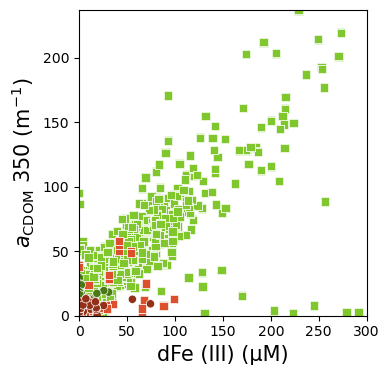

In [12]:
def cor_plot_no_doc(data_frame, data_frame_2, title, save_name):
    # Create a deep copy to prevent modifications outside the function
    data_frame = data_frame.copy()
    data_frame_2 = data_frame_2.copy()
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

    for i, x_var in enumerate(['Fe3_uM']):
        for j, y_var in enumerate([ 'a350']):
            
            ax = axes
            
            # Check if x_var and y_var are the same
            if x_var == y_var:
                ax.set_facecolor('black')
                ax.axis('off')  # This line hides the axis ticks and labels
                continue

            data = data_frame[[x_var, y_var, 'Type']].dropna()
            colors = {'RHZ': '#dc4f2d', 'PW': '#7fc72d'}
            r2_values = {}

            data2 = data_frame_2[[x_var, y_var, 'Type']].dropna()
            colors2 = {'Rhz': '#933018', 'Cent': '#4b7a15'}
            r2_values2 = {}

            # Scatter plot
            sns.scatterplot(x=x_var, y=y_var, data=data, ax=ax, hue='Type', palette=colors, legend=False, marker='s')
            sns.scatterplot(x=x_var, y=y_var, data=data2, ax=ax, hue='Type', palette=colors2, legend=False)
            ax.set_ylim(0, data[y_var].max())
            ax.set_xlim(0, 300)

            for type_, color in colors.items():
                subset = data[data['Type'] == type_]
                subset2 = data2[data2['Type'] == type_]
                if not subset.empty:
                    X1 = subset[[x_var]]
                    y1 = subset[y_var]
                    X2 = subset2[[x_var]]
                    y2 = subset2[y_var]
                    X = np.concatenate([X1, X2], axis=0)  
                    y = np.concatenate([y1, y2], axis=0)  
                    model = LinearRegression().fit(X, y)
                    r2_values[type_] = model.score(X, y)
                    if r2_values[type_] > .25: 
                        pass#sns.lineplot(x=X.flatten(), y=model.predict(X), ax=ax, color=color)
                    else: 
                        pass 

            title_texts = []
            for type_, color in colors.items():
                if type_ in r2_values:
                    title_texts.append(f" R\u00B2: {r2_values[type_]:.2f}")

            #ax.text(.77, .7, title_texts[1], color='b', transform=ax.transAxes, ha='center', fontsize=10)
            #ax.text(.77, .65, title_texts[0], color='r', transform=ax.transAxes, ha='center', fontsize=10)

            # Axis labels
            if j == 0:
                ax.set_xlabel(x_var.replace('Fe2_uM', 'dFe (II) (\u03BCM)').replace('Fe3_uM', 'dFe (III) (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (m$^{-1}$)'), size=15)
            else: 
                ax.set_xlabel("")
            
            if i == 0:
                ax.set_ylabel(y_var.replace('Fe2_uM', 'dFe (II) (\u03BCM)').replace('Fe3_uM', 'dFe (III) (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (m$^{-1}$)'), size=15)
            else: 
                ax.set_ylabel("")

    # Adjust the layout of the subplots
    fig.suptitle(title, size = 15)
    fig.set_facecolor('w')
    plt.tight_layout()

    #plt.savefig(save_name)
    plt.show()

stations = ['St.7', 'St.15', 'St.9', 'St.2', 'St.13']
df_gom_choose = pd.concat([df_pw, df_rz])
df_mds_choose = pd.concat([mds_pw, mds_rz])
df_mds_choose = df_mds_choose[df_mds_choose['a350'] >= 0]
df_mds_choose = df_mds_choose[df_mds_choose['Fe3_uM'] >= 0]


cor_plot_no_doc(df_gom_choose, df_mds_choose,'', '../Dissertation_projects/Figures/Poxy_paper_figs/cor_vs_rhz_fe_cdom_all_data.png')

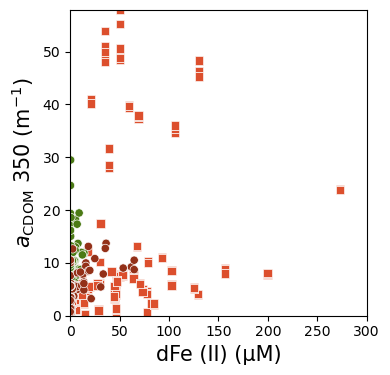

In [19]:
def cor_plot_no_doc(data_frame, data_frame_2, title, save_name):
    # Create a deep copy to prevent modifications outside the function
    data_frame = data_frame.copy()
    data_frame_2 = data_frame_2.copy()
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

    for i, x_var in enumerate(['Fe2_uM']):
        for j, y_var in enumerate([ 'a350']):
            
            ax = axes
            
            # Check if x_var and y_var are the same
            if x_var == y_var:
                ax.set_facecolor('black')
                ax.axis('off')  # This line hides the axis ticks and labels
                continue

            data = data_frame[[x_var, y_var, 'Type']].dropna()
            colors = {'RHZ': '#dc4f2d', 'PW': '#7fc72d'}
            r2_values = {}

            data2 = data_frame_2[[x_var, y_var, 'Type']].dropna()
            colors2 = {'Rhz': '#933018', 'Cent': '#4b7a15'}
            r2_values2 = {}

            # Scatter plot
            sns.scatterplot(x=x_var, y=y_var, data=data, ax=ax, hue='Type', palette=colors, legend=False, marker='s')
            sns.scatterplot(x=x_var, y=y_var, data=data2, ax=ax, hue='Type', palette=colors2, legend=False)
            ax.set_ylim(0, data[y_var].max())
            ax.set_xlim(0, 300)

            for type_, color in colors.items():
                subset = data[data['Type'] == type_]
                subset2 = data2[data2['Type'] == type_]
                if not subset.empty:
                    X1 = subset[[x_var]]
                    y1 = subset[y_var]
                    X2 = subset2[[x_var]]
                    y2 = subset2[y_var]
                    X = np.concatenate([X1, X2], axis=0)  
                    y = np.concatenate([y1, y2], axis=0)  
                    model = LinearRegression().fit(X, y)
                    r2_values[type_] = model.score(X, y)
                    if r2_values[type_] > .25: 
                        pass#sns.lineplot(x=X.flatten(), y=model.predict(X), ax=ax, color=color)
                    else: 
                        pass 

            title_texts = []
            for type_, color in colors.items():
                if type_ in r2_values:
                    title_texts.append(f" R\u00B2: {r2_values[type_]:.2f}")

            #ax.text(.77, .7, title_texts[1], color='b', transform=ax.transAxes, ha='center', fontsize=10)
            #ax.text(.77, .65, title_texts[0], color='r', transform=ax.transAxes, ha='center', fontsize=10)

            # Axis labels
            if j == 0:
                ax.set_xlabel(x_var.replace('Fe2_uM', 'dFe (II) (\u03BCM)').replace('Fe3_uM', 'dFe (III) (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (m$^{-1}$)'), size=15)
            else: 
                ax.set_xlabel("")
            
            if i == 0:
                ax.set_ylabel(y_var.replace('Fe2_uM', 'dFe (II) (\u03BCM)').replace('Fe3_uM', 'dFe (III) (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (m$^{-1}$)'), size=15)
            else: 
                ax.set_ylabel("")

    # Adjust the layout of the subplots
    fig.suptitle(title, size = 15)
    fig.set_facecolor('w')
    plt.tight_layout()

    #plt.savefig(save_name)
    plt.show()

stations = ['St.7', 'St.15', 'St.9', 'St.2', 'St.13']
df_gom_choose = df_rz # pd.concat([df_pw, df_rz])
df_mds_choose = pd.concat([mds_pw, mds_rz])
df_mds_choose = df_mds_choose[df_mds_choose['a350'] >= 0]
df_mds_choose = df_mds_choose[df_mds_choose['Fe3_uM'] >= 0]


cor_plot_no_doc(df_gom_choose, df_mds_choose,'', '../Dissertation_projects/Figures/Poxy_paper_figs/cor_vs_rhz_fe_cdom_all_data.png')

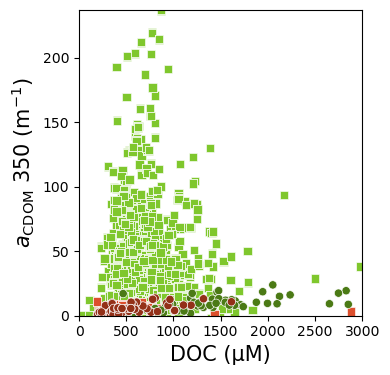

In [14]:
def cor_plot_no_doc(data_frame, data_frame_2, title, save_name):
    # Create a deep copy to prevent modifications outside the function
    data_frame = data_frame.copy()
    data_frame_2 = data_frame_2.copy()
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

    for i, x_var in enumerate(['NPOC_uM']):
        for j, y_var in enumerate([ 'a350']):
            
            ax = axes
            
            # Check if x_var and y_var are the same
            if x_var == y_var:
                ax.set_facecolor('black')
                ax.axis('off')  # This line hides the axis ticks and labels
                continue

            data = data_frame[[x_var, y_var, 'Type']].dropna()
            colors = {'RHZ': '#dc4f2d', 'PW': '#7fc72d'}
            r2_values = {}

            data2 = data_frame_2[[x_var, y_var, 'Type']].dropna()
            colors2 = {'Rhz': '#933018', 'Cent': '#4b7a15'}
            r2_values2 = {}

            # Scatter plot
            sns.scatterplot(x=x_var, y=y_var, data=data, ax=ax, hue='Type', palette=colors, legend=False, marker='s')
            sns.scatterplot(x=x_var, y=y_var, data=data2, ax=ax, hue='Type', palette=colors2, legend=False)
            ax.set_ylim(0, data[y_var].max())
            ax.set_xlim(0, 3000)

            for type_, color in colors.items():
                subset = data[data['Type'] == type_]
                subset2 = data2[data2['Type'] == type_]
                if not subset.empty:
                    X1 = subset[[x_var]]
                    y1 = subset[y_var]
                    X2 = subset2[[x_var]]
                    y2 = subset2[y_var]
                    X = np.concatenate([X1, X2], axis=0)  
                    y = np.concatenate([y1, y2], axis=0)  
                    model = LinearRegression().fit(X, y)
                    r2_values[type_] = model.score(X, y)
                    if r2_values[type_] > .25: 
                        pass#sns.lineplot(x=X.flatten(), y=model.predict(X), ax=ax, color=color)
                    else: 
                        pass 

            title_texts = []
            for type_, color in colors.items():
                if type_ in r2_values:
                    title_texts.append(f" R\u00B2: {r2_values[type_]:.2f}")

            #ax.text(.77, .7, title_texts[1], color='b', transform=ax.transAxes, ha='center', fontsize=10)
            #ax.text(.77, .65, title_texts[0], color='r', transform=ax.transAxes, ha='center', fontsize=10)

            # Axis labels
            if j == 0:
                ax.set_xlabel(x_var.replace('Fe2_uM', 'dFe (II) (\u03BCM)').replace('Fe3_uM', 'dFe (III) (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (m$^{-1}$)'), size=15)
            else: 
                ax.set_xlabel("")
            
            if i == 0:
                ax.set_ylabel(y_var.replace('Fe2_uM', 'dFe (II) (\u03BCM)').replace('Fe3_uM', 'dFe (III) (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (m$^{-1}$)'), size=15)
            else: 
                ax.set_ylabel("")

    # Adjust the layout of the subplots
    fig.suptitle(title, size = 15)
    fig.set_facecolor('w')
    plt.tight_layout()

    #plt.savefig(save_name)
    plt.show()

df_gom_choose = pd.concat([df_pw, df_rz])
cor_vs_rhz_fe_svau = pd.concat([mds_pw, mds_rz])
df_mds_choose = df_mds_choose[df_mds_choose['a350'] >= 0]

#df_mds_choose = df_mds_choose[df_mds_choose['Fe3_uM'] >= 0]


cor_plot_no_doc(df_gom_choose, df_mds_choose,'', '../Dissertation_projects/Figures/Poxy_paper_figs/cor_vs_rhz_fe_cdom_all_data.png')

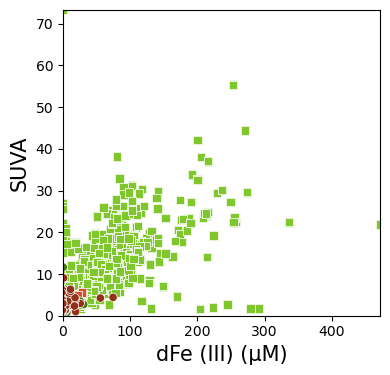

In [15]:
def cor_plot_no_doc(data_frame, data_frame_2, title, save_name):
    # Create a deep copy to prevent modifications outside the function
    data_frame = data_frame.copy()
    data_frame_2 = data_frame_2.copy()
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

    for i, x_var in enumerate(['Fe3_uM']):
        for j, y_var in enumerate([ 'SUVA']):
            
            ax = axes
            
            # Check if x_var and y_var are the same
            if x_var == y_var:
                ax.set_facecolor('black')
                ax.axis('off')  # This line hides the axis ticks and labels
                continue

            data = data_frame[[x_var, y_var, 'Type']].dropna()
            colors = {'RHZ': '#dc4f2d', 'PW': '#7fc72d'}
            r2_values = {}

            data2 = data_frame_2[[x_var, y_var, 'Type']].dropna()
            colors2 = {'Rhz': '#933018', 'Cent': '#4b7a15'}
            r2_values2 = {}

            # Scatter plot
            sns.scatterplot(x=x_var, y=y_var, data=data, ax=ax, hue='Type', palette=colors, legend=False, marker='s')
            sns.scatterplot(x=x_var, y=y_var, data=data2, ax=ax, hue='Type', palette=colors2, legend=False)
            ax.set_ylim(0, data[y_var].max())
            ax.set_xlim(0, data[x_var].max())

            for type_, color in colors.items():
                subset = data[data['Type'] == type_]
                subset2 = data2[data2['Type'] == type_]
                if not subset.empty:
                    X1 = subset[[x_var]]
                    y1 = subset[y_var]
                    X2 = subset2[[x_var]]
                    y2 = subset2[y_var]
                    X = np.concatenate([X1, X2], axis=0)  
                    y = np.concatenate([y1, y2], axis=0)  
                    model = LinearRegression().fit(X, y)
                    r2_values[type_] = model.score(X, y)
                    if r2_values[type_] < .18: 
                        pass#sns.lineplot(x=X.flatten(), y=model.predict(X), ax=ax, color=color)
                    else: 
                        pass 

            title_texts = []
            for type_, color in colors.items():
                if type_ in r2_values:
                    title_texts.append(f" R\u00B2: {r2_values[type_]:.2f}")

            #ax.text(.77, .5, title_texts[1], color='black', transform=ax.transAxes, ha='center', fontsize=10)
            #ax.text(.77, .65, title_texts[0], color='r', transform=ax.transAxes, ha='center', fontsize=10)

            # Axis labels
            if j == 0:
                ax.set_xlabel(x_var.replace('Fe2_uM', 'dFe (II) (\u03BCM)').replace('Fe3_uM', 'dFe (III) (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (m$^{-1}$)'), size=15)
            else: 
                ax.set_xlabel("")
            
            if i == 0:
                ax.set_ylabel(y_var.replace('Fe2_uM', 'dFe (II) (\u03BCM)').replace('Fe3_uM', 'dFe (III) (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (m$^{-1}$)'), size=15)
            else: 
                ax.set_ylabel("")

    # Adjust the layout of the subplots
    fig.suptitle(title, size = 15)
    fig.set_facecolor('w')
    plt.tight_layout()

    #plt.savefig(save_name)
    plt.show()

df_gom_choose = pd.concat([df_pw, df_rz])
df_mds_choose = pd.concat([mds_pw, mds_rz])
df_mds_choose = df_mds_choose[df_mds_choose['a350'] >= 0]

df_gom_choose['SUVA'] = df_gom_choose['a254'] / (df_gom_choose['NPOC_uM'] * 0.012) 
df_mds_choose['SUVA'] = df_mds_choose['a254'] / (df_mds_choose['NPOC_uM'] * 0.012) 

#df_mds_choose = df_mds_choose[df_mds_choose['Fe3_uM'] >= 0]


cor_plot_no_doc(df_gom_choose, df_mds_choose,'', '../Dissertation_projects/Figures/Poxy_paper_figs/cor_vs_rhz_fe_svau_all_data.png')

In [16]:
codes_list_docfe

set(codes_list)

NameError: name 'codes_list_docfe' is not defined

In [ ]:
codes_list_iron = df_iron_rz['code'].unique().tolist()
codes_list_doc = df_doc_rz['code'].unique().tolist()
codes_list_cdom = df_cdom_rz['code'].unique().tolist()

codes_list_all = codes_list_iron + codes_list_doc + codes_list_cdom
codes_list_docfe = codes_list_iron + codes_list_doc 

codes_list_docfe = list(set(codes_list_all))
codes_list_docfe

codes_list = list(set(codes_list_all))
codes_list

df_pw_cut = df_pw[df_pw['code'].isin(codes_list)]
df_pw_cut['code'].unique()
df_gom = pd.concat([df_pw_cut, df_rz])

df_gom['SUVA'] = df_gom['a254'] / (df_gom['NPOC_uM'] * 0.012) 

df_gom_rz = df_gom[df_gom['Type'] == 'RHZ']
df_gom_pw = df_gom[df_gom['Type'] == 'PW']

df_gom_pw

In [ ]:
df_mds = pd.read_csv('../Cruise_2024/Data/Profiles_EIP/IRON_PW_I_E_P.csv', sep=',')
df_mds['Sample_ID'] = df_mds['Sample_ID'].astype(str) 
df_mds.index = df_mds['Sample_ID']
df_mds = df_mds.drop('Sample_ID', axis=1) 

df_mds['SUVA'] = df_mds['a254'] / (df_mds['NPOC_uM'] * 0.012) 
df_mds['SUVA_350'] = df_mds['a350'] / (df_mds['NPOC_uM'] * 0.012) 


df_mds_pw = df_mds[df_mds['Type'] == 'Cent']
df_mds_rz = df_mds[df_mds['Type'] == 'Rhz']

df_mds_rz

In [ ]:
stns = df_mds['Location'].unique()

fig, axes = plt.subplots(1, 3, figsize=(len(stns)*2, 5))

for i, stn in enumerate(stns):
    ax = axes[i]

    ds = df_mds[df_mds['Location']  == stns[i]]
    ds['Depth_CM'] = pd.to_numeric(ds['Depth_CM'], errors='coerce')
    ds = ds[ds['Depth_CM'] >= 0]

    dsc = ds[ds['Type'] == 'Cent']
    dsr = ds[ds['Type'] == 'Rhz']
    
    SUVA_pw = dsc['SUVA'] 
    SUVA_pw = np.asarray(SUVA_pw, dtype=float).ravel()
    fe_pw = dsc['Fe3_uM'] 
    fe_pw = np.asarray(fe_pw, dtype=float).ravel()
    depth_pw = dsc['Depth_CM'] #X var 
    depth_pw = np.asarray(depth_pw, dtype=float).ravel()

    SUVA_rz = dsr['SUVA'] 
    SUVA_rz = np.asarray(SUVA_rz, dtype=float).ravel()
    fe_rz = dsr['Fe3_uM'] 
    fe_rz = np.asarray(fe_rz, dtype=float).ravel()
    depth_rz = dsr['Depth_CM']  # X variable
    depth_rz = np.asarray(depth_rz, dtype=float).ravel()

    s = 12

    ax.plot(SUVA_pw, depth_pw, c = 'b', lw = 1.5,  marker = 'o', markersize = 5, markeredgecolor='black')
    ax.set_title(f'{stn}', size=15)
    ax.set_ylim(15, 0)
    ax.set_xlim(0, 10)

    ax1 = ax.twiny()
    ax1.plot(fe_pw, depth_pw, c = 'r', lw = 1.5,  marker = 'o', markersize = 5,  markeredgecolor='black')
    ax1.set_xlim(0, 75)

    ax3 = ax.twiny()
    ax3.plot(SUVA_rz, depth_rz, c = 'darkblue', lw = 1.5,  marker='s', markersize = 6, markerfacecolor='white', markeredgecolor='darkblue')
    ax3.set_xlim(0, 10)

    ax2 = ax.twiny()
    ax2.plot(fe_rz, depth_rz, c = 'darkred', lw = 1.5,  marker='s', markersize = 6, markerfacecolor='white', markeredgecolor='darkred')
    ax2.set_xlim(0, 75)

    ax.set_ylabel('Depth (cm)', size=15, c='black')
    ax.yaxis.set_tick_params(labelsize=s)

    ax.set_xlabel('SUVA (m$^{-1}$ mgL$^{-1}$)', size=s, c='b')
    ax.xaxis.set_tick_params(labelsize=s)

    ax3.set_xlabel('')
    ax3.xaxis.set_ticklabels([])
    ax3.set_xticks([])

    ax2.set_xlabel('')
    ax2.xaxis.set_ticklabels([])
    ax2.set_xticks([])

    ax1.set_xlabel('dFe(III) (µM)', size = s, c= 'r')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.xaxis.set_label_position('bottom')
    ax1.spines['bottom'].set_position(('outward', 40))
    ax1.xaxis.set_tick_params(labelsize=s)

    
    if i == 0:
        axes[0].set_ylabel('Depth (cm)', size=15, c='black')
        axes[0].yaxis.set_tick_params(labelsize=11)
    else: 
        ax.set_ylabel('')
        ax.yaxis.set_ticklabels([])
        ax.set_yticks([])
        axes[1].set_ylabel('')
        axes[2].set_ylabel('')

    axes[1].set_ylabel('')
    axes[2].set_ylabel('')

plt.tight_layout()
fig.set_facecolor('w')
plt.savefig(f'../Dissertation_projects/Figures/Poxy_paper_figs/Profiles_SUVA_MDS.png')
plt.show()

In [ ]:
df_iron_rz.columns

In [ ]:
df_iron_rz['code'].unique()

In [ ]:
#get PW data sets 
df_cdom_pw = df_cdom[df_cdom['Type'] == 'PW']
df_iron_pw = df_iron[df_iron['Type'] == 'PW']
df_doc_pw = df_doc[df_doc['Type'] == 'PW']

#get RHZ data 
df_cdom_rz = df_cdom[df_cdom['Type'] == 'RHZ']
df_iron_rz = df_iron[df_iron['Type'].isin(['RZ', 'GBRZ'])]
df_doc_rz = df_doc[df_doc['Type'] == 'RZ']

codes_list_iron = df_iron_rz['code'].unique().tolist()
codes_list_doc = df_doc_rz['code'].unique().tolist()
codes_list_cdom = df_cdom_rz['code'].unique().tolist()

codes_list_ironp = df_iron_pw['code'].unique().tolist()
codes_list_docp = df_doc_pw['code'].unique().tolist()
codes_list_cdomp = df_cdom_pw['code'].unique().tolist()

# Find intersection of all three lists
codes_list_common = list(set(codes_list_iron) & set(codes_list_cdom) & set(codes_list_ironp) & set(codes_list_cdomp) )
print(codes_list_common)

codes_list_common = list(set(codes_list_ironp) & set(codes_list_cdomp) )
print(codes_list_common)


In [ ]:
stations = ['St.9', 'St.11',  'St.12', 'St.5B', 'St.MK', 'St.2', 'St.4', 'St.16', 'St.14', 'St.15', 'St.13', 'St.7']
trip_pic = 'GOM22SP'

fig, axes = plt.subplots(1, len(stations), figsize=(len(stations)*2, 5))

for i, stn in enumerate(stations):
    ax = axes[i]

    ds = df_gom[(df_gom['Trip'] == trip_pic) & (df_gom['Station'] == stn)]
    ds['Sample_depth'] = pd.to_numeric(ds['Sample_depth'], errors='coerce')
    ds = ds[ds['Sample_depth'] >= 0]
    
    dsc = ds[ds['Type'] == 'PW']
    dsr = ds[ds['Type'] == 'RHZ']
    
    SUVA_pw = dsc['a350'] 
    SUVA_pw = np.asarray(SUVA_pw, dtype=float).ravel()
    depth_pw = dsc['Sample_depth'] #X var 
    depth_pw = np.asarray(depth_pw, dtype=float).ravel()

    SUVA_rz = dsr['a350'] 
    SUVA_rz = np.asarray(SUVA_rz, dtype=float).ravel()
    depth_rz = dsr['Sample_depth']  # X variable
    depth_rz = np.asarray(depth_rz, dtype=float).ravel()

    ds_rz = df_iron_rz[(df_iron_rz['Campaign'] == trip_pic) & (df_iron_rz['Location'] == stn)]
    ds_rz = ds_rz[ds_rz['FeT_Depth'] >= 0]

    ds_pw = df_iron_pw[(df_iron_pw['Campaign'] == trip_pic) & (df_iron_pw['Location'] == stn)]
    ds_pw = ds_pw[ds_pw['FeT_Depth'] >= 0]
    
    fe3_pw = ds_pw['Fe3_uM'] 
    fe3_pw = np.asarray(fe3_pw, dtype=float).ravel()
    dep_pw = ds_pw['FeT_Depth'] 
    dep_pw = np.asarray(dep_pw, dtype=float).ravel()
    
    fe3_rz = ds_rz['Fe3_uM']
    fe3_rz = np.asarray(fe3_rz, dtype=float).ravel()
    dep_rz = ds_rz['FeT_Depth']
    dep_rz = np.asarray(dep_rz, dtype=float).ravel()

    ax.plot(SUVA_pw, depth_pw, c = 'b', lw = 1.5,  marker = 'o', markersize = 5)
    ax.set_title(f'{stn}', size=15)
    ax.set_ylim(20.25, 0)
    ax.set_xlim(0, 35)

    ax1 = ax.twiny()
    ax1.plot(fe3_pw, dep_pw, c = 'r', lw = 1.5,  marker = 'o', markersize = 5)
    ax1.set_xlim(0, 400)

    ax3 = ax.twiny()
    ax3.plot(SUVA_rz, depth_rz, c = 'darkblue', lw = 1.5, marker='s', markersize = 6, markerfacecolor='white', markeredgecolor='darkblue')
    ax3.set_xlim(0, 35)

    ax2 = ax.twiny()
    ax2.plot(fe3_rz, dep_rz, c = 'darkred', lw = 1.5,  marker = 's', markersize = 6,  markerfacecolor='white', markeredgecolor='darkred')
    ax2.set_xlim(0, 400)


    s = 12

    ax.set_ylabel('Depth (cm)', size=15, c='black')
    ax.yaxis.set_tick_params(labelsize=s)

    ax.set_xlabel(' a cdom 350 (m$^{-1}$ mgL$^{-1}$)', size=s, c='b')
    ax.xaxis.set_tick_params(labelsize=s)

    ax3.set_xlabel('')
    ax3.xaxis.set_ticklabels([])
    ax3.set_xticks([])
    
    ax2.set_xlabel('')
    ax2.xaxis.set_ticklabels([])
    ax2.set_xticks([])

    ax1.set_xlabel(' dFe(III) (µM)', size = s, c= 'r')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.xaxis.set_label_position('bottom')
    ax1.spines['bottom'].set_position(('outward', 40))
    ax1.xaxis.set_tick_params(labelsize=s)

    if i == 0:
        axes[0].set_ylabel('Depth (cm)', size=15, c='black')
        axes[0].yaxis.set_tick_params(labelsize=11)
    else: 
        ax.set_ylabel('')
        ax.yaxis.set_ticklabels([])
        ax.set_yticks([])
        axes[1].set_ylabel('')
        axes[2].set_ylabel('')
        axes[3].set_ylabel('')
        axes[4].set_ylabel('')

    axes[1].set_ylabel('')
    axes[2].set_ylabel('')
    axes[3].set_ylabel('')
    axes[4].set_ylabel('')

plt.tight_layout()
fig.set_facecolor('w')
plt.savefig(f'../Dissertation_projects/Figures/Poxy_paper_figs/Profiles_SUVA_GOM.png')
plt.show()

In [ ]:
stations = ['St.9', 'St.11',  'St.12', 'St.5B', 'St.MK', 'St.2', 'St.4', 'St.16', 'St.14', 'St.15', 'St.13', 'St.7']
trip_pic = 'GOM22SU'

fig, axes = plt.subplots(1, len(stations), figsize=(len(stations)*2, 5))

for i, stn in enumerate(stations):
    ax = axes[i]

    ds = df_gom[(df_gom['Trip'] == trip_pic) & (df_gom['Station'] == stn)]
    ds['Sample_depth'] = pd.to_numeric(ds['Sample_depth'], errors='coerce')
    ds = ds[ds['Sample_depth'] >= 0]
    
    dsc = ds[ds['Type'] == 'PW']
    dsr = ds[ds['Type'] == 'RHZ']
    
    SUVA_pw = dsc['a350'] 
    SUVA_pw = np.asarray(SUVA_pw, dtype=float).ravel()
    depth_pw = dsc['Sample_depth'] #X var 
    depth_pw = np.asarray(depth_pw, dtype=float).ravel()

    SUVA_rz = dsr['a350'] 
    SUVA_rz = np.asarray(SUVA_rz, dtype=float).ravel()
    depth_rz = dsr['Sample_depth']  # X variable
    depth_rz = np.asarray(depth_rz, dtype=float).ravel()

    ds_rz = df_iron_rz[(df_iron_rz['Campaign'] == trip_pic) & (df_iron_rz['Location'] == stn)]
    ds_rz = ds_rz[ds_rz['FeT_Depth'] >= 0]

    ds_pw = df_iron_pw[(df_iron_pw['Campaign'] == trip_pic) & (df_iron_pw['Location'] == stn)]
    ds_pw = ds_pw[ds_pw['FeT_Depth'] >= 0]
    
    fe3_pw = ds_pw['Fe3_uM'] 
    fe3_pw = np.asarray(fe3_pw, dtype=float).ravel()
    dep_pw = ds_pw['FeT_Depth'] 
    dep_pw = np.asarray(dep_pw, dtype=float).ravel()
    
    fe3_rz = ds_rz['Fe3_uM']
    fe3_rz = np.asarray(fe3_rz, dtype=float).ravel()
    dep_rz = ds_rz['FeT_Depth']
    dep_rz = np.asarray(dep_rz, dtype=float).ravel()

    ax.plot(SUVA_pw, depth_pw, c = 'b', lw = 1.5,  marker = 'o', markersize = 5)
    ax.set_title(f'{stn}', size=15)
    ax.set_ylim(20.25, 0)
    ax.set_xlim(0, ds['a350'].max())

    ax1 = ax.twiny()
    ax1.plot(fe3_pw, dep_pw, c = 'r', lw = 1.5,  marker = 'o', markersize = 5)
    ax1.set_xlim(0, 400)

    ax3 = ax.twiny()
    ax3.plot(SUVA_rz, depth_rz, c = 'darkblue', lw = 1.5, marker='s', markersize = 6, markerfacecolor='white', markeredgecolor='darkblue')
    ax3.set_xlim(0, ds['a350'].max())

    ax2 = ax.twiny()
    ax2.plot(fe3_rz, dep_rz, c = 'darkred', lw = 1.5,  marker = 's', markersize = 6,  markerfacecolor='white', markeredgecolor='darkred')
    ax2.set_xlim(0, 400)


    s = 12

    ax.set_ylabel('Depth (cm)', size=15, c='black')
    ax.yaxis.set_tick_params(labelsize=s)

    ax.set_xlabel(' a cdom 350 (m$^{-1}$ mgL$^{-1}$)', size=s, c='b')
    ax.xaxis.set_tick_params(labelsize=s)

    ax3.set_xlabel('')
    ax3.xaxis.set_ticklabels([])
    ax3.set_xticks([])
    
    ax2.set_xlabel('')
    ax2.xaxis.set_ticklabels([])
    ax2.set_xticks([])

    ax1.set_xlabel(' dFe(III) (µM)', size = s, c= 'r')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.xaxis.set_label_position('bottom')
    ax1.spines['bottom'].set_position(('outward', 40))
    ax1.xaxis.set_tick_params(labelsize=s)

    if i == 0:
        axes[0].set_ylabel('Depth (cm)', size=15, c='black')
        axes[0].yaxis.set_tick_params(labelsize=11)
    else: 
        ax.set_ylabel('')
        ax.yaxis.set_ticklabels([])
        ax.set_yticks([])
        axes[1].set_ylabel('')
        axes[2].set_ylabel('')
        axes[3].set_ylabel('')
        axes[4].set_ylabel('')

    axes[1].set_ylabel('')
    axes[2].set_ylabel('')
    axes[3].set_ylabel('')
    axes[4].set_ylabel('')

plt.tight_layout()
fig.set_facecolor('w')
plt.savefig(f'../Dissertation_projects/Figures/Poxy_paper_figs/Profiles_SUVA_GOM.png')
plt.show()

stations = ['St.7', 'St.15', 'St.9', 'St.2', 'St.13']

fig, axes = plt.subplots(1, 2, figsize=(4, 5))

for i, stn in enumerate(stations):
    ax = axes[i]

    ds = df_gom[(df_gom['Trip'] == 'GOM21FA') & (df_gom['Station'] == 'St.MK')]
    ds['Sample_depth'] = pd.to_numeric(ds['Sample_depth'], errors='coerce')
    ds = ds[ds['Sample_depth'] >= 0]

    dm = df_mds[df_mds['Station'] == stn]
    dm['Sample_depth'] = pd.to_numeric(ds['Sample_depth'], errors='coerce')
    dm = dm[dm['Sample_depth'] >= 0]
    
    dsc = ds[ds['Type'] == 'PW']
    dsr = ds[ds['Type'] == 'RHZ']
    
    SUVA_pw = dsc['SUVA'] 
    SUVA_pw = np.asarray(SUVA_pw, dtype=float).ravel()
    fe3_pw = dsc['Fe3_uM'] 
    fe3_pw = np.asarray(fe3_pw, dtype=float).ravel()
    cdom_pw = dsc['a350'] 
    cdom_pw = np.asarray(cdom_pw, dtype=float).ravel()
    depth_pw = dsc['Sample_depth'] #X var 
    depth_pw = np.asarray(depth_pw, dtype=float).ravel()

    SUVA_rz = dsr['SUVA'] 
    SUVA_rz = np.asarray(SUVA_rz, dtype=float).ravel()
    fe3_rz = dsr['Fe3_uM']
    fe3_rz = np.asarray(fe3_rz, dtype=float).ravel()
    cdom_rz = dsr['a350']
    cdom_rz = np.asarray(cdom_rz, dtype=float).ravel()
    depth_rz = dsr['Sample_depth']  # X variable
    depth_rz = np.asarray(depth_rz, dtype=float).ravel()

    ax.plot(SUVA_pw, depth_pw, c = 'b', lw = 1.5,  marker = 'o', markersize = 5)
    ax.set_title(f'{stn}', size=15)
    ax.set_ylim(20.25, 0)
    ax.set_xlim(0, 35)
    
    ax3 = ax.twiny()
    ax3.plot(SUVA_rz, depth_rz, c = 'darkblue', lw = 1.5,  marker = 'o', markersize = 5)
    ax3.set_xlim(0, 35)

    #ax1 = ax.twiny()
    #ax1.plot(cdom_pw, depth_pw, c = 'r', lw = 1.5,  marker = 'o', markersize = 5)
    #ax1.set_xlim(0, 300)

    #ax2 = ax.twiny()
    #ax2.plot(cdom_rz, cdom_rz, c = 'darkred', lw = 1.5,  marker = 'o', markersize = 5)
    #ax2.set_xlim(0, 300)


    if i == 0:
        axes[0].set_ylabel('Depth cm', size=7, c='black')
        axes[0].yaxis.set_tick_params(labelsize=7)
    else: 
        ax.set_ylabel('')
        ax.yaxis.set_ticklabels([])
        ax.set_yticks([])
        axes[1].set_ylabel('')
        axes[2].set_ylabel('')
        axes[3].set_ylabel('')
        axes[4].set_ylabel('')


    s = 14

    ax.set_ylabel('Depth cm', size=s, c='black')
    ax.yaxis.set_tick_params(labelsize=s)

    ax.set_xlabel('Centrifuge SUVA \n (m$^{-1}$ mgL$^{-1}$)', size=s, c='b')
    ax.xaxis.set_tick_params(labelsize=s)

    ax3.set_xlabel('Rhizon SUVA \n (m$^{-1}$ mgL$^{-1}$)', size = s, c= 'darkblue')
    ax3.xaxis.set_ticks_position('bottom')
    ax3.xaxis.set_label_position('bottom')
    ax3.spines['bottom'].set_position(('outward', 65))
    ax3.xaxis.set_tick_params(labelsize=s)

plt.tight_layout()
fig.set_facecolor('w')
#plt.savefig(f'../Dissertation_projects/Figures/Poxy_paper_figs/Profiles_SUVA_GOM.png')
plt.show()

In [ ]:
def cor_plot_no_doc(data_frame, data_frame_2, title, save_name):
    # Create a deep copy to prevent modifications outside the function
    data_frame = data_frame.copy()
    data_frame_2 = data_frame_2.copy()
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

    for i, x_var in enumerate(['Fe3_uM']):
        for j, y_var in enumerate([ 'SUVA']):
            
            ax = axes
            
            # Check if x_var and y_var are the same
            if x_var == y_var:
                ax.set_facecolor('black')
                ax.axis('off')  # This line hides the axis ticks and labels
                continue

            data = data_frame[[x_var, y_var, 'Type']].dropna()
            colors = {'RHZ': '#dc4f2d', 'PW': '#7fc72d'}
            r2_values = {}

            data2 = data_frame_2[[x_var, y_var, 'Type']].dropna()
            colors2 = {'Rhz': '#933018', 'Cent': '#4b7a15'}
            r2_values2 = {}

            # Scatter plot
            sns.scatterplot(x=x_var, y=y_var, data=data, ax=ax, hue='Type', palette=colors, legend=False, marker='s')
            sns.scatterplot(x=x_var, y=y_var, data=data2, ax=ax, hue='Type', palette=colors2, legend=False)
            ax.set_ylim(0, data[y_var].max())
            ax.set_xlim(0, data[x_var].max())

            for type_, color in colors.items():
                subset = data[data['Type'] == type_]
                subset2 = data2[data2['Type'] == type_]
                if not subset.empty:
                    X1 = subset[[x_var]]
                    y1 = subset[y_var]
                    X2 = subset2[[x_var]]
                    y2 = subset2[y_var]
                    X = np.concatenate([X1, X2], axis=0)  
                    y = np.concatenate([y1, y2], axis=0)  
                    model = LinearRegression().fit(X, y)
                    r2_values[type_] = model.score(X, y)
                    if r2_values[type_] < .18: 
                        pass#sns.lineplot(x=X.flatten(), y=model.predict(X), ax=ax, color=color)
                    else: 
                        pass 

            title_texts = []
            for type_, color in colors.items():
                if type_ in r2_values:
                    title_texts.append(f" R\u00B2: {r2_values[type_]:.2f}")

            #ax.text(.77, .5, title_texts[1], color='black', transform=ax.transAxes, ha='center', fontsize=10)
            #ax.text(.77, .65, title_texts[0], color='r', transform=ax.transAxes, ha='center', fontsize=10)

            # Axis labels
            if j == 0:
                ax.set_xlabel(x_var.replace('Fe2_uM', 'dFe (II) (\u03BCM)').replace('Fe3_uM', 'dFe (III) (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (m$^{-1}$)'), size=15)
            else: 
                ax.set_xlabel("")
            
            if i == 0:
                ax.set_ylabel(y_var.replace('Fe2_uM', 'dFe (II) (\u03BCM)').replace('Fe3_uM', 'dFe (III) (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (m$^{-1}$)'), size=15)
            else: 
                ax.set_ylabel("")

    # Adjust the layout of the subplots
    fig.suptitle(title, size = 15)
    fig.set_facecolor('w')
    plt.tight_layout()

    #plt.savefig(save_name)
    plt.show()

stations = ['St.7', 'St.15', 'St.9', 'St.2', 'St.13']
df_gom_choose = df_gom[(df_gom['Trip'] == 'GOM22SP') & (df_gom['Station'].isin(stations))]

cor_plot_no_doc(df_gom_choose, df_mds,'', '../Dissertation_projects/Figures/Poxy_paper_figs/cor_vs_rhz_fe_svau.png')

In [ ]:
def cor_plot_no_doc(data_frame, data_frame_2, title, save_name):
    # Create a deep copy to prevent modifications outside the function
    data_frame = data_frame.copy()
    data_frame_2 = data_frame_2.copy()
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

    for i, x_var in enumerate(['Fe3_uM']):
        for j, y_var in enumerate(['a350']):
            
            ax = axes
            
            # Check if x_var and y_var are the same
            if x_var == y_var:
                ax.set_facecolor('black')
                ax.axis('off')  # This line hides the axis ticks and labels
                continue

            data = data_frame[[x_var, y_var, 'Type']].dropna()
            colors = {'RHZ': '#dc4f2d', 'PW': '#7fc72d'}
            r2_values = {}

            data2 = data_frame_2[[x_var, y_var, 'Type']].dropna()
            colors2 = {'Rhz': '#933018', 'Cent': '#4b7a15'}
            r2_values2 = {}

            # Scatter plot
            sns.scatterplot(x=x_var, y=y_var, data=data, ax=ax, hue='Type', palette=colors, legend=False, marker='s')
            sns.scatterplot(x=x_var, y=y_var, data=data2, ax=ax, hue='Type', palette=colors2, legend=False)
            ax.set_ylim(0, data[y_var].max())
            ax.set_xlim(0, data[x_var].max())

            for type_, color in colors.items():
                subset = data[data['Type'] == type_]
                subset2 = data2[data2['Type'] == type_]
                if not subset.empty:
                    X1 = subset[[x_var]]
                    y1 = subset[y_var]
                    X2 = subset2[[x_var]]
                    y2 = subset2[y_var]
                    X = np.concatenate([X1, X2], axis=0)  
                    y = np.concatenate([y1, y2], axis=0)  
                    model = LinearRegression().fit(X, y)
                    r2_values[type_] = model.score(X, y)
                    if r2_values[type_] > .25: 
                        pass#sns.lineplot(x=X.flatten(), y=model.predict(X), ax=ax, color=color)
                    else: 
                        pass 

            title_texts = []
            for type_, color in colors.items():
                if type_ in r2_values:
                    title_texts.append(f" R\u00B2: {r2_values[type_]:.2f}")

            #ax.text(.77, .7, title_texts[1], color='b', transform=ax.transAxes, ha='center', fontsize=10)
            #ax.text(.77, .65, title_texts[0], color='r', transform=ax.transAxes, ha='center', fontsize=10)

            # Axis labels
            if j == 0:
                ax.set_xlabel(x_var.replace('Fe2_uM', 'dFe (II) (\u03BCM)').replace('Fe3_uM', 'dFe (III) (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (m$^{-1}$)'), size=15)
            else: 
                ax.set_xlabel("")
            
            if i == 0:
                ax.set_ylabel(y_var.replace('Fe2_uM', 'dFe (II) (\u03BCM)').replace('Fe3_uM', 'dFe (III) (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (m$^{-1}$)'), size=15)
            else: 
                ax.set_ylabel("")

    # Adjust the layout of the subplots
    fig.suptitle(title, size = 15)
    fig.set_facecolor('w')
    plt.tight_layout()

    #plt.savefig(save_name)
    plt.show()

stations = ['St.7', 'St.15', 'St.9', 'St.2', 'St.13']
df_gom_choose = df_gom[(df_gom['Trip'] == 'GOM22SP') & (df_gom['Station'].isin(stations))]

cor_plot_no_doc(df_gom_choose, df_mds,'', '../Dissertation_projects/Figures/Poxy_paper_figs/cor_vs_rhz_fe_cdom.png')

In [ ]:
def cor_plot_no_doc(data_frame, data_frame_2, title, save_name):
    # Create a deep copy to prevent modifications outside the function
    data_frame = data_frame.copy()
    data_frame_2 = data_frame_2.copy()
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

    for i, x_var in enumerate(['NPOC_uM']):
        for j, y_var in enumerate([ 'a350']):
            
            ax = axes
            
            # Check if x_var and y_var are the same
            if x_var == y_var:
                ax.set_facecolor('black')
                ax.axis('off')  # This line hides the axis ticks and labels
                continue

            data = data_frame[[x_var, y_var, 'Type']].dropna()
            colors = {'RHZ': '#dc4f2d', 'PW': '#7fc72d'}
            r2_values = {}

            data2 = data_frame_2[[x_var, y_var, 'Type']].dropna()
            colors2 = {'Rhz': '#933018', 'Cent': '#4b7a15'}
            r2_values2 = {}

            # Scatter plot
            sns.scatterplot(x=x_var, y=y_var, data=data, ax=ax, hue='Type', palette=colors, legend=False, marker='s')
            sns.scatterplot(x=x_var, y=y_var, data=data2, ax=ax, hue='Type', palette=colors2, legend=False)
            ax.set_ylim(0, data[y_var].max())
            ax.set_xlim(0, data[x_var].max())

            for type_, color in colors.items():
                subset = data[data['Type'] == type_]
                subset2 = data2[data2['Type'] == type_]
                if not subset.empty:
                    X1 = subset[[x_var]]
                    y1 = subset[y_var]
                    X2 = subset2[[x_var]]
                    y2 = subset2[y_var]
                    X = np.concatenate([X1, X2], axis=0)  
                    y = np.concatenate([y1, y2], axis=0)  
                    model = LinearRegression().fit(X, y)
                    r2_values[type_] = model.score(X, y)
                    #sns.lineplot(x=X.flatten(), y=model.predict(X), ax=ax, color=color)

            title_texts = []
            for type_, color in colors.items():
                if type_ in r2_values:
                    title_texts.append(f" R\u00B2: {r2_values[type_]:.2f}")

            #ax.text(.77, .7, title_texts[1], color='b', transform=ax.transAxes, ha='center', fontsize=10)
            #ax.text(.77, .65, title_texts[0], color='r', transform=ax.transAxes, ha='center', fontsize=10)

            # Axis labels
            if j == 0:
                ax.set_xlabel(x_var.replace('Fe2_uM', 'dFe (II) (\u03BCM)').replace('Fe3_uM', 'dFe (III) (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (m$^{-1}$)'), size=15)
            else: 
                ax.set_xlabel("")
            
            if i == 0:
                ax.set_ylabel(y_var.replace('Fe2_uM', 'dFe (II) (\u03BCM)').replace('Fe3_uM', 'dFe (III) (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (m$^{-1}$)'), size=15)
            else: 
                ax.set_ylabel("")

    # Adjust the layout of the subplots
    fig.suptitle(title, size = 15)
    fig.set_facecolor('w')
    plt.tight_layout()

    plt.savefig(save_name)
    plt.show()

stations = ['St.7', 'St.15', 'St.9', 'St.2', 'St.13']
df_gom_choose = df_gom[(df_gom['Trip'] == 'GOM22SP') & (df_gom['Station'].isin(stations))]


cor_plot_no_doc(df_gom_choose, df_mds,'', '../Dissertation_projects/Figures/Poxy_paper_figs/cor_vs_rhz_doc_cdom.png')

In [ ]:
stop

In [ ]:
def cor_plot_no_doc(data_frame, title, save_name):
    # Create a deep copy to prevent modifications outside the function
    data_frame = data_frame.copy()
    
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))

    for i, x_var in enumerate(['Fe2_uM', 'Fe3_uM', 'NPOC_uM']):
        for j, y_var in enumerate([ 'a412', 'a350']):
            
            ax = axes[j, i]
            
            # Check if x_var and y_var are the same
            if x_var == y_var:
                ax.set_facecolor('black')
                ax.axis('off')  # This line hides the axis ticks and labels
                continue

            data = data_frame[[x_var, y_var, 'Type']].dropna()
            colors = {'RHZ': 'red', 'PW': 'blue'}
            r2_values = {}

            # Scatter plot
            sns.scatterplot(x=x_var, y=y_var, data=data, ax=ax, hue='Type', palette=colors, legend=False)
            ax.set_ylim(0, data[y_var].max() * 1.1)
            ax.set_xlim(0, data[x_var].max() * 1.1)

            for type_, color in colors.items():
                subset = data[data['Type'] == type_]
                if not subset.empty:
                    X = subset[[x_var]]
                    y = subset[y_var]
                    model = LinearRegression().fit(X, y)
                    r2_values[type_] = model.score(X, y)
                    sns.lineplot(x=X[x_var], y=model.predict(X), ax=ax, color=color)

            title_texts = []
            for type_, color in colors.items():
                if type_ in r2_values:
                    title_texts.append(f" R\u00B2: {r2_values[type_]:.2f}")

            ax.text(.7, .8, title_texts[1], color='b', transform=ax.transAxes, ha='center', fontsize=10)
            ax.text(.7, .7, title_texts[0], color='r', transform=ax.transAxes, ha='center', fontsize=10)

            # Axis labels
            if j == 1:
                ax.set_xlabel(x_var.replace('Fe2_uM', 'dFe (II) (\u03BCM)').replace('Fe3_uM', 'dFe (III) (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'), size=10)
            else: 
                ax.set_xlabel("")
            
            if i == 0:
                ax.set_ylabel(y_var.replace('Fe2_uM', 'dFe (II) (\u03BCM)').replace('Fe3_uM', 'dFe (III) (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'), size=10)
            else: 
                ax.set_ylabel("")

    # Adjust the layout of the subplots
    fig.suptitle(title, size = 15)
    fig.set_facecolor('w')
    plt.tight_layout()

    plt.savefig(save_name)
    plt.show()

df = pd.concat([df_pw, df_rz])
df = df[df['NPOC_uM'] <= 2000]

cor_plot_no_doc(df, f'Pore Water Centrifuge vs Rhizon \n', '../Dissertation_projects/Figures/Rhizon_vs_Cent/cor_vs_rhz_GOM.png')

In [ ]:
def cor_plot_no_doc(data_frame, title, save_name):
    # Create a deep copy to prevent modifications outside the function
    data_frame = data_frame.copy()
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

    for i, x_var in enumerate(['Fe2_uM']):
        for j, y_var in enumerate([ 'a350']):
            
            ax = axes
            
            # Check if x_var and y_var are the same
            if x_var == y_var:
                ax.set_facecolor('black')
                ax.axis('off')  # This line hides the axis ticks and labels
                continue

            data = data_frame[[x_var, y_var, 'Type']].dropna()
            colors = {'RHZ': 'red', 'PW': 'blue'}
            r2_values = {}

            # Scatter plot
            sns.scatterplot(x=x_var, y=y_var, data=data, ax=ax, hue='Type', palette=colors, legend=False)
            ax.set_ylim(0, data[y_var].max())
            ax.set_xlim(0, data[x_var].max())

            for type_, color in colors.items():
                subset = data[data['Type'] == type_]
                if not subset.empty:
                    X = subset[[x_var]]
                    y = subset[y_var]
                    model = LinearRegression().fit(X, y)
                    r2_values[type_] = model.score(X, y)
                    sns.lineplot(x=X[x_var], y=model.predict(X), ax=ax, color=color)

            title_texts = []
            for type_, color in colors.items():
                if type_ in r2_values:
                    title_texts.append(f" R\u00B2: {r2_values[type_]:.2f}")

            ax.text(.7, .8, title_texts[1], color='b', transform=ax.transAxes, ha='center', fontsize=10)
            ax.text(.7, .75, title_texts[0], color='r', transform=ax.transAxes, ha='center', fontsize=10)

            # Axis labels
            if j == 0:
                ax.set_xlabel(x_var.replace('Fe2_uM', 'dFe (II) (\u03BCM)').replace('Fe3_uM', 'dFe (III) (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'), size=15)
            else: 
                ax.set_xlabel("")
            
            if i == 0:
                ax.set_ylabel(y_var.replace('Fe2_uM', 'dFe (II) (\u03BCM)').replace('Fe3_uM', 'dFe (III) (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'), size=15)
            else: 
                ax.set_ylabel("")

    # Adjust the layout of the subplots
    fig.suptitle(title, size = 15)
    fig.set_facecolor('w')
    plt.tight_layout()

    plt.savefig(save_name)
    plt.show()

df = pd.concat([df_pw, df_rz])

cor_plot_no_doc(df, '', '../Dissertation_projects/Figures/Poxy_paper_figs/cor_vs_rhz_GOM_fe_cdom.png')

In [ ]:
def cor_plot_no_doc(data_frame, title, save_name):
    # Create a deep copy to prevent modifications outside the function
    data_frame = data_frame.copy()
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

    for i, x_var in enumerate(['NPOC_uM']):
        for j, y_var in enumerate([ 'a350']):
            
            ax = axes
            
            # Check if x_var and y_var are the same
            if x_var == y_var:
                ax.set_facecolor('black')
                ax.axis('off')  # This line hides the axis ticks and labels
                continue

            data = data_frame[[x_var, y_var, 'Type']].dropna()
            colors = {'RHZ': 'red', 'PW': 'blue'}
            r2_values = {}

            # Scatter plot
            sns.scatterplot(x=x_var, y=y_var, data=data, ax=ax, hue='Type', palette=colors, legend=False)
            ax.set_ylim(0, data[y_var].max())
            ax.set_xlim(0, data[x_var].max())

            for type_, color in colors.items():
                subset = data[data['Type'] == type_]
                if not subset.empty:
                    X = subset[[x_var]]
                    y = subset[y_var]
                    model = LinearRegression().fit(X, y)
                    r2_values[type_] = model.score(X, y)
                    sns.lineplot(x=X[x_var], y=model.predict(X), ax=ax, color=color)

            title_texts = []
            for type_, color in colors.items():
                if type_ in r2_values:
                    title_texts.append(f" R\u00B2: {r2_values[type_]:.2f}")

            ax.text(.7, .8, title_texts[1], color='b', transform=ax.transAxes, ha='center', fontsize=10)
            ax.text(.7, .75, title_texts[0], color='r', transform=ax.transAxes, ha='center', fontsize=10)

            # Axis labels
            if j == 0:
                ax.set_xlabel(x_var.replace('Fe2_uM', 'dFe (II) (\u03BCM)').replace('Fe3_uM', 'dFe (III) (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'), size=15)
            else: 
                ax.set_xlabel("")
            
            if i == 0:
                ax.set_ylabel(y_var.replace('Fe2_uM', 'dFe (II) (\u03BCM)').replace('Fe3_uM', 'dFe (III) (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'), size=15)
            else: 
                ax.set_ylabel("")

    # Adjust the layout of the subplots
    fig.suptitle(title, size = 15)
    fig.set_facecolor('w')
    plt.tight_layout()

    plt.savefig(save_name)
    plt.show()

df = pd.concat([df_pw, df_rz])

cor_plot_no_doc(df, '', '../Dissertation_projects/Figures/Poxy_paper_figs/cor_vs_rhz_GOM_doc_cdom.png')

In [ ]:
def cor_plot_no_doc(data_frame, title, save_name):
    # Create a deep copy to prevent modifications outside the function
    data_frame = data_frame.copy()
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

    for i, x_var in enumerate(['Fe2_uM', 'NPOC_uM']):
        for j, y_var in enumerate([ 'a350']):
            
            ax = axes[ i]
            
            # Check if x_var and y_var are the same
            if x_var == y_var:
                ax.set_facecolor('black')
                ax.axis('off')  # This line hides the axis ticks and labels
                continue

            data = data_frame[[x_var, y_var, 'Type']].dropna()
            colors = {'RHZ': 'red', 'PW': 'blue'}
            r2_values = {}

            # Scatter plot
            sns.scatterplot(x=x_var, y=y_var, data=data, ax=ax, hue='Type', palette=colors, legend=False)
            ax.set_ylim(0, data[y_var].max())
            ax.set_xlim(0, data[x_var].max())

            for type_, color in colors.items():
                subset = data[data['Type'] == type_]
                if not subset.empty:
                    X = subset[[x_var]]
                    y = subset[y_var]
                    model = LinearRegression().fit(X, y)
                    r2_values[type_] = model.score(X, y)
                    sns.lineplot(x=X[x_var], y=model.predict(X), ax=ax, color=color)

            title_texts = []
            for type_, color in colors.items():
                if type_ in r2_values:
                    title_texts.append(f" R\u00B2: {r2_values[type_]:.2f}")

            ax.text(.7, .8, title_texts[1], color='b', transform=ax.transAxes, ha='center', fontsize=10)
            ax.text(.7, .7, title_texts[0], color='r', transform=ax.transAxes, ha='center', fontsize=10)

            # Axis labels
            if j == 0:
                ax.set_xlabel(x_var.replace('Fe2_uM', 'dFe (II) (\u03BCM)').replace('Fe3_uM', 'dFe (III) (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'), size=10)
            else: 
                ax.set_xlabel("")
            
            if i == 0:
                ax.set_ylabel(y_var.replace('Fe2_uM', 'dFe (II) (\u03BCM)').replace('Fe3_uM', 'dFe (III) (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'), size=10)
            else: 
                ax.set_ylabel("")

    # Adjust the layout of the subplots
    fig.suptitle(title, size = 15)
    fig.set_facecolor('w')
    plt.tight_layout()

    plt.savefig(save_name)
    plt.show()

df = pd.concat([df_pw, df_rz])
df2 = df[df['NPOC_uM'] <= 2000]

cor_plot_no_doc(df, '', '../Dissertation_projects/Figures/Poxy_paper_figs/cor_vs_rhz_GOM.png')

In [ ]:
def xyplotcolor_data(df):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    model = LinearRegression()
    sub = df.dropna(subset=[x_var, y_var])
    data = sub[[x_var, y_var, z_var]]
    colors = data[z_var].astype(float)

    vmin = data[z_var].min()
    vmax = data[z_var].max()

    X = data[[x_var]]
    y = data[y_var]
    model.fit(X, y)
    score = model.score(X, y)
    
    
    sns.scatterplot(x=x_var, y=y_var, c=colors, cmap=z_var_color,marker ="o", s=100, alpha = .9, data=data, ax=axes, legend=False, vmin=vmin, vmax=vmax)
    sns.lineplot(x=X[x_var], y=model.predict(X), ax=axes, color='black')
    
    axes.set_xlabel(x_var.replace(x_var, x_var_lab), size=15)
    axes.set_ylabel(y_var.replace(y_var, y_var_lab), size=15)
    axes.set_ylim(0, data[y_var].max()*1.1)
    axes.set_xlim(0, data[x_var].max()*1.1)

    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=z_var_color, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel(z_var_lab, size=15)

    # Show the plot
    #plt.savefig(f'../Dissertation_projects/Figures/CTD_profiles/{save_name}.png')
    plt.show()

    
y_var = 'a350'
y_var_lab = r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'

z_var = 'NPOC_uM'
z_var_lab = 'DOC (µM)'

x_var = 'Fe3_uM'
x_var_lab = 'dFe (III) (\u03BCM)'
z_var_color = cmo.matter

titel = " df_pw "
save_name = 'df_pw'
df_pw = df_pw[df_pw['NPOC_uM'] <= 2000]
xyplotcolor_data(df_pw)


In [ ]:

x_var = 'sav'
x_var_lab = 'SAV'

y_var = 'Fe3_uM'
y_var_lab = 'dFe (III) (\u03BCM)'

z_var = 'NPOC_uM'
z_var_lab = 'DOC (µM)'
z_var_color = cmo.matter

titel = " df_rz "
save_name = 'df_rz'
df_rz['fexdoc'] = df_rz['NPOC_uM'] * df_rz['FeT_uM']
df_rz['sav'] =  df_rz['NPOC_uM'] / df_rz['a254']

#df_rzu = df_rz[df_rz['sav'] <= 100]
xyplotcolor_data(df_rz)

In [ ]:
def cor_plot(data_frame, title, save_name):
    # Create a deep copy to prevent modifications outside the function
    data_frame = data_frame.copy()
    
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

    for i, x_var in enumerate(['Fe2_uM', 'Fe3_uM', 'NPOC_uM', 'a412', 'a350']):
        for j, y_var in enumerate(['Fe2_uM', 'Fe3_uM', 'NPOC_uM', 'a412', 'a350']):
            
            ax = axes[j, i]
            
            # Check if x_var and y_var are the same
            if x_var == y_var:
                ax.set_facecolor('black')
                ax.axis('off')  # This line hides the axis ticks and labels
                continue

            data = data_frame[[x_var, y_var, 'Type']].dropna()
            colors = {'RHZ': 'red', 'PW': 'blue'}
            r2_values = {}

            # Scatter plot
            sns.scatterplot(x=x_var, y=y_var, data=data, ax=ax, hue='Type', palette=colors, legend=False)
            sns.plt.ylim(0,)
            sns.plt.xlim(0,)


            for type_, color in colors.items():
                subset = data[data['Type'] == type_]
                if not subset.empty:
                    X = subset[[x_var]]
                    y = subset[y_var]
                    model = LinearRegression().fit(X, y)
                    r2_values[type_] = model.score(X, y)
                    sns.lineplot(x=X[x_var], y=model.predict(X), ax=ax, color=color)

            title_texts = []
            for type_, color in colors.items():
                if type_ in r2_values:
                    title_texts.append(f"{type_} R\u00B2: {r2_values[type_]:.2f}")

            for idx, text in enumerate(title_texts):
                type_from_text = text.split(' ')[0]  # Extract the type (PW or RZ) from the text string
                ax.text(0.5, 1.15 - idx * 0.1, text, color=colors[type_from_text], transform=ax.transAxes, ha='center', fontsize=15)

            # Axis labels
            if j == 4:
                ax.set_xlabel(x_var.replace('Fe2_uM', 'Fe (II) (\u03BCM)').replace('Fe3_uM', 'Fe (III) (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'), size=15)
            elif j == 3 and i == 4: 
                ax.set_xlabel(x_var.replace('Fe2_uM', 'Fe (II) (\u03BCM)').replace('Fe3_uM', 'Fe (III) (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'), size=15)
            else: 
                ax.set_xlabel("")
            if i == 0:
                ax.set_ylabel(y_var.replace('Fe2_uM', 'Fe (II) (\u03BCM)').replace('Fe3_uM', 'Fe (III) (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'), size=15)
            elif i == 1 and j == 0:
                ax.set_ylabel(y_var.replace('Fe2_uM', 'Fe (II) (\u03BCM)').replace('Fe3_uM', 'Fe (III) (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'), size=15)
            else: 
                ax.set_ylabel("")

    # Adjust the layout of the subplots
    fig.suptitle(title, size = 15)
    fig.set_facecolor('w')
    plt.tight_layout()

    plt.savefig(save_name)
    plt.show()

df = df_pw[df_pw['code'].isin(codes_list_docfe)]
df = df.loc[df['Depth'] < 16.5]
df = pd.concat([df, df_rz])

cor_plot(df, f'Pore Water Centrifuge vs Rhizon \n', '../Dissertation_projects/Figures/Rhizon_vs_Cent/cor_vs.png')


In [ ]:
def cor_plot_no_doc(data_frame, title, save_name):
    # Create a deep copy to prevent modifications outside the function
    data_frame = data_frame.copy()
    
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))

    for i, x_var in enumerate(['Fe2_uM', 'Fe3_uM', 'a412', 'a350']):
        for j, y_var in enumerate(['Fe2_uM', 'Fe3_uM', 'a412', 'a350']):
            
            ax = axes[j, i]
            
            # Check if x_var and y_var are the same
            if x_var == y_var:
                ax.set_facecolor('black')
                ax.axis('off')  # This line hides the axis ticks and labels
                continue

            data = data_frame[[x_var, y_var, 'Type']].dropna()
            colors = {'RHZ': 'red', 'PW': 'blue'}
            r2_values = {}

            # Scatter plot
            sns.scatterplot(x=x_var, y=y_var, data=data, ax=ax, hue='Type', palette=colors, legend=False)

            for type_, color in colors.items():
                subset = data[data['Type'] == type_]
                if not subset.empty:
                    X = subset[[x_var]]
                    y = subset[y_var]
                    model = LinearRegression().fit(X, y)
                    r2_values[type_] = model.score(X, y)
                    sns.lineplot(x=X[x_var], y=model.predict(X), ax=ax, color=color)

            title_texts = []
            for type_, color in colors.items():
                if type_ in r2_values:
                    title_texts.append(f"{type_} R\u00B2: {r2_values[type_]:.2f}")

            for idx, text in enumerate(title_texts):
                type_from_text = text.split(' ')[0]  # Extract the type (PW or RZ) from the text string
                ax.text(0.5, 1.15 - idx * 0.1, text, color=colors[type_from_text], transform=ax.transAxes, ha='center', fontsize=15)

            # Axis labels
            if j == 3:
                ax.set_xlabel(x_var.replace('Fe2_uM', 'Fe (II) (\u03BCM)').replace('Fe3_uM', 'Fe (III) (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'), size=15)
            elif j == 2 and i == 3: 
                ax.set_xlabel(x_var.replace('Fe2_uM', 'Fe (II) (\u03BCM)').replace('Fe3_uM', 'Fe (III) (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'), size=15)
            else: 
                ax.set_xlabel("")
            if i == 0:
                ax.set_ylabel(y_var.replace('Fe2_uM', 'Fe (II) (\u03BCM)').replace('Fe3_uM', 'Fe (III) (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'), size=15)
            elif i == 1 and j == 0:
                ax.set_ylabel(y_var.replace('Fe2_uM', 'Fe (II) (\u03BCM)').replace('Fe3_uM', 'Fe (III) (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('a412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'), size=15)
            else: 
                ax.set_ylabel("")

    # Adjust the layout of the subplots
    fig.suptitle(title, size = 15)
    fig.set_facecolor('w')
    plt.tight_layout()

    plt.savefig(save_name)
    plt.show()

df = df_pw[df_pw['code'].isin(['St.12_GOM21FA', 'St.13_GOM21FA', 'St.2_GOM21FA',
                               'St.14_GOM21FA', 'St.11_GOM21FA', 'St.16_GOM21FA',
                               'St.9_GOM21FA', 'St.MK_GOM21FA'])]
df = df.loc[df['Depth'] < 16.5]
df_rz['Type'] = "RHZ"
df_rz_sub = df_rz[df_rz['code'].isin(['St.12_GOM21FA', 'St.13_GOM21FA', 'St.2_GOM21FA',
                                      'St.14_GOM21FA', 'St.11_GOM21FA', 'St.16_GOM21FA',
                                      'St.9_GOM21FA', 'St.MK_GOM21FA'])]
df = pd.concat([df, df_rz_sub])

cor_plot_no_doc(df, f'Pore Water Centrifuge vs Rhizon \n', '../Dissertation_projects/Figures/Rhizon_vs_Cent/cor_vs_fall.png')


In [ ]:
df_1 = df_pw[df_pw['code'].isin(['St.15_GOM22SP', 'St.13_GOM22SP', 'St.4_GOM22SP',
                               'St.14_GOM22SP','St.5B_GOM22SP','St.MK_GOM22SP',
                               'St.2_GOM22SP', 'St.16_GOM22SP', 'St.9_GOM22SP',
                               'St.7_GOM22SP'])]
df_2 = df_1.loc[df_1['Depth'] < 16.5]
df_rz_sub = df_rz[df_rz['code'].isin(['St.15_GOM22SP', 'St.13_GOM22SP', 'St.4_GOM22SP',
                                      'St.14_GOM22SP','St.5B_GOM22SP','St.MK_GOM22SP',
                                      'St.2_GOM22SP', 'St.16_GOM22SP', 'St.9_GOM22SP',
                                      'St.7_GOM22SP'])]
df = pd.concat([df_2, df_rz_sub])

cor_plot(df, f'Pore Water Centrifuge vs Rhizon \n', '../Dissertation_projects/Figures/Rhizon_vs_Cent/cor_vs_spring.png')


In [ ]:
df = df_pw[df_pw['code'].isin([ 'St.MK_GOM22SU','St.7_GOM22SU','St.13_GOM22SU',
                               'St.11_GOM22SU', 'St.4_GOM22SU', 'St.5B_GOM22SU',
                               'St.14_GOM22SU', 'St.16_GOM22SU'])]
df = df.loc[df['Depth'] < 16.5]
df_rz_sub = df_rz[df_rz['code'].isin([ 'St.MK_GOM22SU','St.7_GOM22SU','St.13_GOM22SU',
                                      'St.11_GOM22SU', 'St.4_GOM22SU', 'St.5B_GOM22SU',
                                      'St.14_GOM22SU', 'St.16_GOM22SU'])]
df = pd.concat([df, df_rz_sub])

cor_plot_no_doc(df, f'Pore Water Centrifuge vs Rhizon \n', '../Dissertation_projects/Figures/Rhizon_vs_Cent/cor_vs_summer.png')


In [ ]:
df_spectra_pw.index = df_spectra_pw.index.astype(str)
df_spectra_rz.index = df_spectra_rz.index.astype(str)
df_meta.index = df_meta.index.astype(str)

df_spectra_pw = df_spectra_pw.merge(df_meta, left_index=True, right_index=True)
df_spectra_rz = df_spectra_rz.merge(df_meta, left_index=True, right_index=True)

In [ ]:
codes_list

In [ ]:
for code in codes_list: 
    #get data 
    data_cdom_pw = df_cdom_pw[df_cdom_pw['code'] == code] 
    data_cdom_rz = df_cdom_rz[df_cdom_rz['code'] == code]
    data_spectra_pw = df_spectra_pw[df_spectra_pw['code'] == code] 
    data_spectra_rz = df_spectra_rz[df_spectra_rz['code'] == code]
    data_iron_pw = df_iron_pw[df_iron_pw['code'] == code] 
    data_iron_rz = df_iron_rz[(df_iron_rz['code'] == code) & (df_iron_rz['Type'] == 'RZ')]
    data_iron_gb = df_iron_rz[(df_iron_rz['code'] == code) & (df_iron_rz['Type'] == 'GBRZ')]
    data_doc_pw = df_doc_pw[df_doc_pw['code'] == code] 
    data_doc_rz = df_doc_rz[df_doc_rz['code'] == code]
    
    #For Pore Waters 
    #get vars DOC 
    doc_uM_pw = data_doc_pw['NPOC_uM'] 
    doc_uM_pw = np.asarray(doc_uM_pw, dtype=float).ravel()
    tn_uM_pw = data_doc_pw['TN_uM'] 
    tn_uM_pw = np.asarray(tn_uM_pw, dtype=float).ravel()
    doc_depth_pw = data_doc_pw['Depth'] #X var 
    doc_depth_pw = np.asarray(doc_depth_pw, dtype=float).ravel()
    
    #get vars Fe
    fe2_uM_pw = data_iron_pw['Fe2_uM'] 
    fe2_uM_pw = np.asarray(fe2_uM_pw, dtype=float).ravel()
    fet_uM_pw = data_iron_pw['FeT_uM'] 
    fet_uM_pw = np.asarray(fet_uM_pw, dtype=float).ravel()
    fe3_uM_pw = data_iron_pw['Fe3_uM'] 
    fe3_uM_pw = np.asarray(fe3_uM_pw, dtype=float).ravel()
    fe_depth_pw = data_iron_pw['Fe2_Depth'] 
    fe_depth_pw = np.asarray(fe_depth_pw, dtype=float).ravel()
    
    #get vars CDOM
    a350_pw = data_spectra_pw['a350']
    a350_pw = np.asarray(a350_pw, dtype=float).ravel()
    aDepth_pw = data_spectra_pw['Sample_depth']
    aDepth_pw = np.asarray(aDepth_pw, dtype=float).ravel()
    
    #For Rhizon Waters
    # get vars DOC 
    doc_uM_rz = data_doc_rz['NPOC_uM'] 
    doc_uM_rz = np.asarray(doc_uM_rz, dtype=float).ravel()
    tn_uM_rz = data_doc_rz['TN_uM'] 
    tn_uM_rz = np.asarray(tn_uM_rz, dtype=float).ravel()
    doc_depth_rz = data_doc_rz['Depth'] #X var 
    doc_depth_rz = np.asarray(doc_depth_rz, dtype=float).ravel()

    # get vars Fe
    fe2_uM_rz = data_iron_rz['Fe2_uM'] 
    fe2_uM_rz = np.asarray(fe2_uM_rz, dtype=float).ravel()
    fet_uM_rz = data_iron_rz['FeT_uM'] 
    fet_uM_rz = np.asarray(fet_uM_rz, dtype=float).ravel()
    fe3_uM_rz = data_iron_rz['Fe3_uM'] 
    fe3_uM_rz = np.asarray(fe3_uM_rz, dtype=float).ravel()
    fe_depth_rz = data_iron_rz['Fe2_Depth'] 
    fe_depth_rz = np.asarray(fe_depth_rz, dtype=float).ravel()
    
    #get vars Fe glove bag 
    fe2_uM_gb = data_iron_gb['Fe2_uM'] 
    fe2_uM_gb = np.asarray(fe2_uM_gb, dtype=float).ravel()
    fet_uM_gb = data_iron_gb['FeT_uM'] 
    fet_uM_gb = np.asarray(fet_uM_gb, dtype=float).ravel()
    fe3_uM_gb = data_iron_gb['Fe3_uM'] 
    fe3_uM_gb = np.asarray(fe3_uM_gb, dtype=float).ravel()
    fe_depth_gb = data_iron_gb['Fe2_Depth'] 
    fe_depth_gb = np.asarray(fe_depth_gb, dtype=float).ravel()
    
    # get vars CDOM
    a350_rz = data_spectra_rz['a350']
    a350_rz = np.asarray(a350_rz, dtype=float).ravel()
    aDepth_rz = data_spectra_rz['Sample_depth']
    aDepth_rz = np.asarray(aDepth_rz, dtype=float).ravel()
    
    # Set up the color bar limits
    vmin = -.5
    vmax = 17
    scale_fac = 45
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(4, 9))
    
    #PLOT DOC cent 
    ax[0].plot(doc_uM_pw, doc_depth_pw, 'o', ls='-', c='black')
    ax[0].set_xlim(0,2000)
    ax[0].set_ylim(17,-1)
    ax[0].axhline(y=0, color='grey', linestyle='-', label='Sediment Water Interface')
    ax[0].set_title('Centrifuge Pore Water')
    ax[0].xaxis.set_ticks_position('bottom')
    ax[0].xaxis.set_label_position('bottom')
    ax[0].spines['bottom'].set_position(('outward', 0))
    ax[0].set_xlabel('DOC (\u03BCM)', size= 10)

    #PLOT DOC rhizon 
    ax[1].plot(doc_uM_rz, doc_depth_rz, 'o', ls='-', c='black')
    ax[1].set_xlim(0,2000)
    ax[1].set_ylim(17,-1)
    ax[1].axhline(y=0, color='grey', linestyle='-', label='Sediment Water Interface')
    ax[1].set_title('Rhizon Pore Water')
    ax[1].xaxis.set_ticks_position('bottom')
    ax[1].xaxis.set_label_position('bottom')
    ax[1].spines['bottom'].set_position(('outward', 0))
    ax[1].set_xlabel('DOC (\u03BCM)', size= 10)
        
    #plot Fe2 cent
    ax01 = ax[0].twiny()
    ax01.plot(fe2_uM_pw, fe_depth_pw, 'o', ls='-', c='b')
    ax01.set_xlim(0,200)
    # Set x-axis label on bottom subplots
    ax01.xaxis.set_ticks_position('bottom')
    ax01.xaxis.set_label_position('bottom')
    ax01.spines['bottom'].set_position(('outward', scale_fac))
    ax01.set_xlabel('Fe(II) (\u03BCM)', size= 10, c='b')
    
    #plot Fe2 rhz
    ax11 = ax[1].twiny()
    ax11.plot(fe2_uM_rz, fe_depth_rz, 'o', ls='-', c='b')
    ax11.set_xlim(0,200)
    # Set x-axis label on bottom subplots
    ax11.xaxis.set_ticks_position('bottom')
    ax11.xaxis.set_label_position('bottom')
    ax11.spines['bottom'].set_position(('outward', scale_fac))
    ax11.set_xlabel('Fe(II) (\u03BCM)', size= 10, c='b')
    
    #plot Fe3 cent
    ax02 = ax[0].twiny()
    ax02.plot(fe3_uM_pw, fe_depth_pw, 'o', ls='-', c='r')
    ax02.set_xlim(0,200)
    # Set x-axis label on bottom subplots
    ax02.xaxis.set_ticks_position('bottom')
    ax02.xaxis.set_label_position('bottom')
    ax02.spines['bottom'].set_position(('outward', scale_fac*2))
    ax02.set_xlabel('Fe(III) (\u03BCM)', size= 10, c='r')
    
    #plot Fe3 rhz
    ax12 = ax[1].twiny()
    ax12.plot(fe3_uM_rz, fe_depth_rz, 'o', ls='-', c='r')
    ax12.set_xlim(0,200)
    # Set x-axis label on bottom subplots
    ax12.xaxis.set_ticks_position('bottom')
    ax12.xaxis.set_label_position('bottom')
    ax12.spines['bottom'].set_position(('outward', scale_fac*2))
    ax12.set_xlabel('Fe(III) (\u03BCM)', size= 10, c='r')
    
    #plot cdom cent
    ax03 = ax[0].twiny()
    ax03.plot(a350_pw, aDepth_pw, 'o', ls='-', c='y')
    ax03.set_xlim(0,236)
    # Set x-axis label on bottom subplots
    ax03.xaxis.set_ticks_position('bottom')
    ax03.xaxis.set_label_position('bottom')
    ax03.spines['bottom'].set_position(('outward', scale_fac*3))
    ax03.set_xlabel('aCDOM 350 (nm)', size= 10, c='y')
    
    #plot cdom rhz
    ax13 = ax[1].twiny()
    ax13.plot(a350_rz, aDepth_rz, 'o', ls='-', c='y')
    ax13.set_xlim(0,236)
    # Set x-axis label on bottom subplots
    ax13.xaxis.set_ticks_position('bottom')
    ax13.xaxis.set_label_position('bottom')
    ax13.spines['bottom'].set_position(('outward', scale_fac*3))
    ax13.set_xlabel('aCDOM 350 (nm)', size= 10, c='y')
    
    #plot Fe2 rhz glove bag 
    ax111 = ax[1].twiny()
    ax111.plot(fe2_uM_gb, fe_depth_gb, 'o', ls='-', c='darkblue')
    ax111.set_xlim(0,200)
    # Set x-axis label on bottom subplots
    ax111.xaxis.set_ticks_position('bottom')
    ax111.xaxis.set_label_position('bottom')
    ax111.spines['bottom'].set_position(('outward', scale_fac*4))
    ax111.set_xlabel('glove bag Fe(II) (\u03BCM)', size= 10, c='darkblue')
    
    #plot Fe3 rhz glove bag 
    ax122 = ax[1].twiny()
    ax122.plot(fe3_uM_gb, fe_depth_gb, 'o', ls='-', c='darkred')
    ax122.set_xlim(0,200)
    # Set x-axis label on bottom subplots
    ax122.xaxis.set_ticks_position('bottom')
    ax122.xaxis.set_label_position('bottom')
    ax122.spines['bottom'].set_position(('outward', scale_fac*5))
    ax122.set_xlabel('glove bag Fe(III) (\u03BCM)', size= 10, c='darkred')
    
    fig.suptitle(code, size = 10)
    
    fig.set_facecolor('w')
    plt.tight_layout()
    plt.savefig(f'../Dissertation_projects/Figures/Rhizon_vs_Cent/profile_{code}.png')
    plt.show()
    